In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import librosa
from complexPyTorch.complexLayers import ComplexLinear
from complexPyTorch.complexFunctions import complex_relu
import matplotlib.pyplot as plt

C:\Users\OwnerDell\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to compute FFT
def fft_transform(data, length):
    """
    Compute FFT of data
    ----------
    Parameters:
    - data (torch.Tensor): The input data of shape (batch_size, signal_length)
    
    Returns:
    - real and imaginary components (torch.Tensors)
    """
    data_fft = torch.fft.fft(data, dim=1, n=length)
    real_data = data_fft.real
    imag_data = data_fft.imag
    return real_data, imag_data

# Custom Dataset for FSDD
class FSDDDataset(Dataset):
    def __init__(self, data_dir, limit=None, length=1000):
        """
        Initialize the FSDD dataset.

        Parameters:
        - data_dir (str): Path to the recordings directory.
        - limit (int, optional): Limit the number of samples for faster experimentation.
        - length (int): Number of FFT points.
        """
        self.data_dir = data_dir
        self.length = length

        # Load file paths and labels
        self.file_paths = []; self.labels = []
        for filename in os.listdir(data_dir):
            if filename.endswith('.wav'):
                self.file_paths.append(os.path.join(data_dir, filename))
                # Label is the first character of the filename (digit)
                label_str = filename.split('_')[0]
                if label_str.isdigit():
                    label = int(label_str)
                else:
                    raise ValueError(f"Invalid label in filename: {filename}")
                self.labels.append(label)

        # Ensure consistency
        assert len(self.file_paths) == len(self.labels), "Mismatch between files and labels."

        # Apply limit if specified
        if limit is not None:
            self.file_paths = self.file_paths[:limit]
            self.labels = self.labels[:limit]
        
        self.num_classes = 10  # Digits 0-9

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load audio
        waveform, sample_rate = torchaudio.load(self.file_paths[idx])  # Shape: (channels, samples)
        waveform = waveform.mean(dim=0)  # Convert to mono by averaging channels
        waveform = waveform / torch.max(torch.abs(waveform))  # Normalize to [-1, 1]

        # Ensure consistent length (e.g., 1 second at 8kHz: 8000 samples)
        if waveform.size(0) < self.length:
            padding = self.length - waveform.size(0)
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            waveform = waveform[:self.length]
        
        # Compute FFT
        real, imag = fft_transform(waveform.unsqueeze(0), self.length)  # Shape: (1, length)
        real_flat = real.squeeze(0); imag_flat = imag.squeeze(0);  # Shape: (length,)
        features = torch.cat((real_flat, imag_flat), dim=0)  # Shape: (2 * length,)

        label = self.labels[idx]
        return features, torch.tensor(label, dtype=torch.long)

In [3]:
# Define the neural network models
class SteinmetzNetwork(nn.Module):
    def __init__(self, dN, num_classes, lN):
        super(SteinmetzNetwork, self).__init__()
        self.real_net = nn.Sequential(nn.Linear(dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN//2), nn.ReLU())
        self.imag_net = nn.Sequential(nn.Linear(dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN//2), nn.ReLU())
        self.regressor = nn.Sequential(
            nn.Linear(lN, num_classes)
        )
    def forward(self, real, imag):
        real_features = self.real_net(real)
        imag_features = self.imag_net(imag)
        # Mean centering imaginary features
        imag_features = imag_features - imag_features.mean(dim=0, keepdim=True)
        combined = torch.cat((real_features, imag_features), dim=1)
        output = self.regressor(combined)
        return output, real_features, imag_features

class NeuralNetwork(nn.Module):
    def __init__(self, dN, num_classes, lN):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(nn.Linear(2*dN, lN//2), nn.ReLU(), nn.Linear(lN//2, lN), nn.ReLU(), nn.Linear(lN, num_classes))
    def forward(self, real, imag):
        input = torch.cat((real, imag), dim=1)
        output = self.net(input)
        return output

class ComplexNeuralNetwork(nn.Module):
    def __init__(self, dN, num_classes, lN):
        super(ComplexNeuralNetwork, self).__init__()
        self.fc1 = ComplexLinear(dN, lN//2)
        self.fc2 = ComplexLinear(lN//2, lN)
        self.fc3 = ComplexLinear(lN, num_classes)
    def forward(self, real, imag):
        complex_tensor = torch.stack((real, imag), dim=-1)
        x = torch.view_as_complex(complex_tensor)
        x = complex_relu(self.fc1(x))
        x = complex_relu(self.fc2(x))
        x = self.fc3(x)
        output = torch.sqrt(torch.real(x)**2 + torch.imag(x)**2)
        return output

In [25]:
def fft_based_hilbert_transform(real_features):
    """
    Apply the FFT-based Hilbert transform to the real features to obtain the imaginary part.

    Parameters:
    - real_features (torch.Tensor): The input real features.

    Returns:
    - transformed_imag (torch.Tensor): The transformed imaginary features obtained from the Hilbert transform.
    """
    # Perform FFT
    fft_result = torch.fft.fft(real_features, dim=-1)

    # Get the number of samples and create a tensor to hold the phase shifts
    N = real_features.shape[-1]
    phase_shift = torch.zeros_like(fft_result)

    # Apply a -90 degree phase shift for positive frequencies (1 to N/2 - 1)
    # and a +90 degree phase shift for negative frequencies (N/2 + 1 to N - 1)
    if N % 2 == 0:
        # Even number of samples
        phase_shift[..., 1:N//2] = -1j  # Positive frequencies (excluding Nyquist)
        phase_shift[..., N//2+1:] = 1j  # Negative frequencies
    else:
        # Odd number of samples
        phase_shift[..., 1:(N+1)//2] = -1j  # Positive frequencies
        phase_shift[..., (N+1)//2:] = 1j   # Negative frequencies

    # Apply phase shift and perorm inverse FFT
    shifted_fft_result = fft_result * phase_shift
    transformed_imag = torch.fft.ifft(shifted_fft_result, dim=-1).real

    return transformed_imag

# Custom loss function for Analytic Neural Network
def custom_loss(outputs, target, real_features, imag_features):
    # Implementing hilbert consistency penalty + custom loss function
    transformed_imag = fft_based_hilbert_transform(real_features)
    consistency_penalty = nn.functional.mse_loss(transformed_imag, imag_features)
    beta = 1e-6 # tradeoff parameter
    return nn.CrossEntropyLoss()(outputs, target) + beta*consistency_penalty

In [33]:
# Hyperparameters
epochs = 30
iterations = 1
dN = 8000  # Number of features in real part after FFT
lN = 200  # Adjust as needed
batch_size = 100

# Create Datasets and DataLoaders
full_dataset = FSDDDataset(data_dir='data/FSDD', limit=None, length=dN)
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
num_classes = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize loss function
criterion = nn.CrossEntropyLoss()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize arrays to store errors and accuracies
train_error_rvnn = np.zeros((iterations, epochs))
train_error_cvnn = np.zeros((iterations, epochs))
train_error_steinmetz = np.zeros((iterations, epochs))
train_error_analytic = np.zeros((iterations, epochs))
test_error_rvnn = np.zeros((iterations, epochs))
test_error_cvnn = np.zeros((iterations, epochs))
test_error_steinmetz = np.zeros((iterations, epochs))
test_error_analytic = np.zeros((iterations, epochs))

# Training and evaluation loop
for iter in range(iterations):
    # Initialize models and optimizers
    model_rvnn = NeuralNetwork(dN=dN, num_classes=num_classes, lN=lN)
    model_cvnn = ComplexNeuralNetwork(dN=dN, num_classes=num_classes, lN=lN)
    model_steinmetz = SteinmetzNetwork(dN=dN, num_classes=num_classes, lN=lN)
    model_analytic = SteinmetzNetwork(dN=dN, num_classes=num_classes, lN=lN)
    optimizer_rvnn = optim.Adam(model_rvnn.parameters(), lr=2e-4)
    optimizer_cvnn = optim.Adam(model_cvnn.parameters(), lr=2e-4)
    optimizer_steinmetz = optim.Adam(model_steinmetz.parameters(), lr=2e-4)
    optimizer_analytic = optim.Adam(model_analytic.parameters(), lr=2e-4)
    model_rvnn.to(device)
    model_cvnn.to(device)
    model_steinmetz.to(device)
    model_analytic.to(device)
    print(f'Iteration {iter+1}/{iterations}')
    print(f'RVNN params: {sum(p.numel() for p in model_rvnn.parameters())}, '
          f'CVNN params: {sum(p.numel() for p in model_cvnn.parameters())}, '
          f'Steinmetz params: {sum(p.numel() for p in model_steinmetz.parameters())}, '
          f'Analytic params: {sum(p.numel() for p in model_analytic.parameters())}')

    # Training Loop
    for epoch in range(epochs):
        model_rvnn.train(); model_cvnn.train(); model_steinmetz.train(); model_analytic.train()
        train_losses_rvnn, train_losses_cvnn, train_losses_steinmetz, train_losses_analytic = [], [], [], []
        for batch_idx, (features, labels) in enumerate(train_loader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs_rvnn = model_rvnn(features[:, :dN], features[:, dN:])
            outputs_cvnn = model_cvnn(features[:, :dN], features[:, dN:])
            outputs_steinmetz, _, _ = model_steinmetz(features[:, :dN], features[:, dN:])
            outputs_analytic, real_feat, imag_feat = model_analytic(features[:, :dN], features[:, dN:])

            loss_rvnn = criterion(outputs_rvnn, labels)
            loss_cvnn = criterion(outputs_cvnn, labels)
            loss_steinmetz = criterion(outputs_steinmetz, labels)
            loss_analytic = custom_loss(outputs_analytic, labels, real_feat, imag_feat)

            _, predicted_rvnn = torch.max(outputs_rvnn.data, 1)
            _, predicted_cvnn = torch.max(outputs_cvnn.data, 1)
            _, predicted_steinmetz = torch.max(outputs_steinmetz.data, 1)
            _, predicted_analytic = torch.max(outputs_analytic.data, 1)

            accuracy_rvnn = (predicted_rvnn == labels).sum().item() / labels.size(0)
            accuracy_cvnn = (predicted_cvnn == labels).sum().item() / labels.size(0)
            accuracy_steinmetz = (predicted_steinmetz == labels).sum().item() / labels.size(0)
            accuracy_analytic = (predicted_analytic == labels).sum().item() / labels.size(0)

            # Backward and optimize
            optimizer_rvnn.zero_grad(); optimizer_steinmetz.zero_grad(); optimizer_analytic.zero_grad(); optimizer_cvnn.zero_grad();
            loss_rvnn.backward(); loss_steinmetz.backward(); loss_analytic.backward(); loss_cvnn.backward();
            optimizer_rvnn.step(); optimizer_steinmetz.step(); optimizer_analytic.step(); optimizer_cvnn.step();

            train_losses_rvnn.append(accuracy_rvnn)
            train_losses_cvnn.append(accuracy_cvnn)
            train_losses_steinmetz.append(accuracy_steinmetz)
            train_losses_analytic.append(accuracy_analytic)

        # Evaluation on Test Set
        model_rvnn.eval(); model_cvnn.eval(); model_steinmetz.eval(); model_analytic.eval()
        test_losses_rvnn, test_losses_cvnn, test_losses_steinmetz, test_losses_analytic = [], [], [], []
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)

                # Forward pass
                outputs_rvnn = model_rvnn(features[:, :dN], features[:, dN:])
                outputs_cvnn = model_cvnn(features[:, :dN], features[:, dN:])
                outputs_steinmetz, _, _ = model_steinmetz(features[:, :dN], features[:, dN:])
                outputs_analytic, _, _ = model_analytic(features[:, :dN], features[:, dN:])
                
                loss_rvnn = criterion(outputs_rvnn, labels)
                loss_cvnn = criterion(outputs_cvnn, labels)
                loss_steinmetz = criterion(outputs_steinmetz, labels)
                loss_analytic = custom_loss(outputs_analytic, labels, real_feat, imag_feat)
    
                _, predicted_rvnn = torch.max(outputs_rvnn.data, 1)
                _, predicted_cvnn = torch.max(outputs_cvnn.data, 1)
                _, predicted_steinmetz = torch.max(outputs_steinmetz.data, 1)
                _, predicted_analytic = torch.max(outputs_analytic.data, 1)
    
                accuracy_rvnn = (predicted_rvnn == labels).sum().item() / labels.size(0)
                accuracy_cvnn = (predicted_cvnn == labels).sum().item() / labels.size(0)
                accuracy_steinmetz = (predicted_steinmetz == labels).sum().item() / labels.size(0)
                accuracy_analytic = (predicted_analytic == labels).sum().item() / labels.size(0)
                
                test_losses_rvnn.append(accuracy_rvnn)
                test_losses_cvnn.append(accuracy_cvnn)
                test_losses_steinmetz.append(accuracy_steinmetz)
                test_losses_analytic.append(accuracy_analytic)

        train_error_rvnn[iter,epoch] = np.mean(train_losses_rvnn)*100
        train_error_cvnn[iter,epoch] = np.mean(train_losses_cvnn)*100
        train_error_steinmetz[iter,epoch] = np.mean(train_losses_steinmetz)*100
        train_error_analytic[iter,epoch] = np.mean(train_losses_analytic)*100
        test_error_rvnn[iter,epoch] = np.mean(test_losses_rvnn)*100
        test_error_cvnn[iter,epoch] = np.mean(test_losses_cvnn)*100
        test_error_steinmetz[iter,epoch] = np.mean(test_losses_steinmetz)*100
        test_error_analytic[iter,epoch] = np.mean(test_losses_analytic)*100

        print(f'Iteration [{iter}/{iterations}], Epoch [{epoch}/{epochs}], RVNN Acc: {test_error_rvnn[iter,epoch]:.4f}, CVNN Acc: {test_error_cvnn[iter,epoch]:.4f}, Steinmetz Acc: {test_error_steinmetz[iter,epoch]:.4f}, Analytic Acc: {test_error_analytic[iter,epoch]:.4f}')

Mean RVNN:       20.0667, STDEV RVNN:      1.0355
Mean CVNN:       20.72, STDEV CVNN:      1.0062
Mean Steinmetz:       24.6, STDEV RVNN:      1.2587
Mean Analytic:       25.02, STDEV CVNN:      0.7487


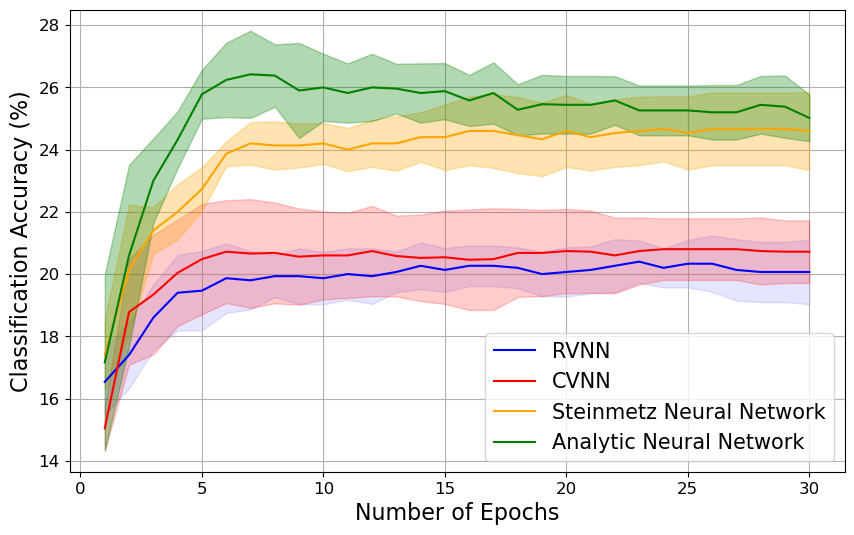

In [32]:
# Step 2: Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=0)
    std_error = np.std(data, axis=0) / np.sqrt(data.shape[0])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Compute mean and CI for accuracies
mean_X, ci_X = compute_mean_and_CI(test_error_rvnn)
mean_Y, ci_Y = compute_mean_and_CI(test_error_cvnn)
mean_Z, ci_Z = compute_mean_and_CI(test_error_steinmetz)
mean_A, ci_A = compute_mean_and_CI(test_error_analytic)

print(f'Mean RVNN:       {mean_X[len(mean_X)-1].round(4)}, STDEV RVNN:      {ci_X[len(ci_X)-1].round(4)}')
print(f'Mean CVNN:       {mean_Y[len(mean_Y)-1].round(4)}, STDEV CVNN:      {ci_Y[len(ci_Y)-1].round(4)}')
print(f'Mean Steinmetz:       {mean_Z[len(mean_Z)-1].round(4)}, STDEV RVNN:      {ci_Z[len(ci_Z)-1].round(4)}')
print(f'Mean Analytic:       {mean_A[len(mean_A)-1].round(4)}, STDEV CVNN:      {ci_A[len(ci_A)-1].round(4)}')

# Step 3: Plot the results
epochs_all = list(range(1, epochs + 1))
plt.figure(figsize=(10, 6))

# Plotting for X
plt.fill_between(epochs_all, mean_X - ci_X, mean_X + ci_X, color='blue', alpha=0.1, zorder=0)
plt.plot(epochs_all, mean_X, 'b-', label="RVNN", zorder=20)

# Plotting for Y
plt.fill_between(epochs_all, mean_Y - ci_Y, mean_Y + ci_Y, color='red', alpha=0.2, zorder=5)
plt.plot(epochs_all, mean_Y, 'r-', label="CVNN", zorder=25)

# Plotting for Z
plt.fill_between(epochs_all, mean_Z - ci_Z, mean_Z + ci_Z, color='orange', alpha=0.3, zorder=10)
plt.plot(epochs_all, mean_Z, '-', color='orange', label="Steinmetz Neural Network", zorder=30)

# Plotting for A
plt.fill_between(epochs_all, mean_A - ci_A, mean_A + ci_A, color='green', alpha=0.3, zorder=15)
plt.plot(epochs_all, mean_A, 'g-', label="Analytic Neural Network", zorder=35)

# Additional plot settings
plt.xlabel("Number of Epochs", fontsize=16)
plt.ylabel("Classification Accuracy (%)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15})
plt.grid(True)
plt.savefig('Results/FSDD_epochs.png', bbox_inches='tight')
plt.show()